#Project Diary
This document act as a project diary for **Happy Tweeting**



###Citation Information
@InProceedings{paws2019naacl,<br>
title = {{TSATC: Twitter Sentiment Analysis Training Corpus}},<br>
author = {Ibrahim Naji},<br>
booktitle = {thinknook},<br>
year = {2012}<br>
}

1 stands for positive,<br>
0 for negative

Dataset retrieved from:<br>
https://huggingface.co/datasets/carblacac/twitter-sentiment-analysis/tree/main

In [ ]:
_URL = "https://raw.githubusercontent.com/cblancac/SentimentAnalysisBert/main/data/"
_URLS = {
    "train": _URL + "train_150k.txt",
    "test": _URL + "test_62k.txt",
}


In [ ]:
!wget https://raw.githubusercontent.com/cblancac/SentimentAnalysisBert/main/data/train_150k.txt
!wget https://raw.githubusercontent.com/cblancac/SentimentAnalysisBert/main/data/test_62k.txt

--2023-06-26 12:56:08--  https://raw.githubusercontent.com/cblancac/SentimentAnalysisBert/main/data/train_150k.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11697788 (11M) [text/plain]
Saving to: ‘train_150k.txt’

train_150k.txt      100%[===================>]  11.16M  --.-KB/s    in 0.09s   

2023-06-26 12:56:09 (118 MB/s) - ‘train_150k.txt’ saved [11697788/11697788]

--2023-06-26 12:56:09--  https://raw.githubusercontent.com/cblancac/SentimentAnalysisBert/main/data/test_62k.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
dfTrain = pd.read_csv("./train_150k.txt",names=["sentiment","tweets"], sep="\t")
dfTest = pd.read_csv("./test_62k.txt",names=["sentiment","tweets"], sep="\t")
dfTrain.head()

,sentiment,tweets
0,0,Starting back at work today Looks like it'l...
1,1,Sugar levels dropping... munchies setting in. ...
2,1,@karineb22 yeah!!! have a great summer break!
3,1,hannah montana was very good. now going to re...
4,1,"@Mayra326 aww, have fun! I just had my 3D las..."


In [ ]:
words = {}
lens = []
for row in dfTrain["tweets"]:
  for word in row.split():
    lens.append(len(row.split()))
    if word in words.keys():
      words[word] += 1
    else:
      words[word] = 1

words_sorted = dict(sorted(words.items(), key=lambda item: item[1], reverse=True))

In [ ]:
lens.sort(reverse=True)

(array([4.914000e+05, 1.012431e+06, 4.900260e+05, 6.030000e+02,
        4.600000e+01, 5.700000e+01, 0.000000e+00, 7.900000e+01,
        0.000000e+00, 1.110000e+02]),
 array([  1.,  12.,  23.,  34.,  45.,  56.,  67.,  78.,  89., 100., 111.]),
 <BarContainer object of 10 artists>)

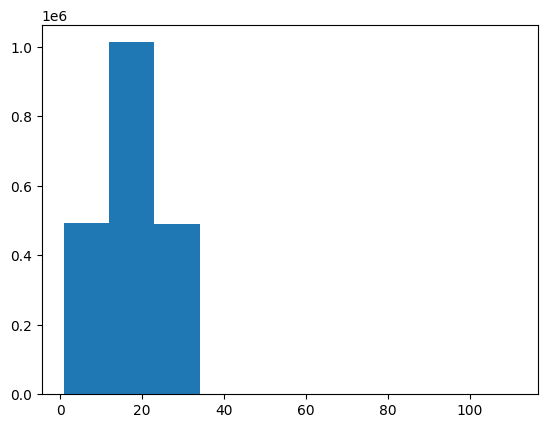

In [ ]:
plt.hist(lens)

In [ ]:
l95 = np.percentile(lens,95)

In [ ]:
len(words_sorted.keys()), sum(words_sorted.values())

(236155, 1994753)

In [ ]:
incremental = {}
current_increment = 0
increments = []
for key in words_sorted.keys():
  current_increment += words_sorted[key]
  increments.append(current_increment)
  incremental[current_increment] = key

p95 = int(sum(words_sorted.values())/100*95)
p95

1895015

In [ ]:
array = np.asarray(increments)
idx = (np.abs(array - p95)).argmin()
tokens = array[idx]

In [ ]:
incremental[tokens]

"ea'.."

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
      ("tfidf", TfidfVectorizer()),
      ("clf",MultinomialNB())
])

model_0.fit(dfTrain["tweets"],dfTrain["sentiment"])


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0_score = model_0.score(dfTest["tweets"],dfTest["sentiment"])

In [ ]:
model_0_score*100

75.93309461595535

In [ ]:
model_0_predictions = model_0.predict(dfTest["tweets"])

In [ ]:
model_0_predictions[:5]

array([1, 0, 0, 0, 0])

In [ ]:
from sklearn import metrics
def evaluate_predictions(y_true,y_pred):
  output = {}
  output["accuracy"] = metrics.accuracy_score(y_true=y_true,
                                                      y_pred=y_pred)
  output["precision"] = metrics.precision_score(y_true=y_true,
                                                      y_pred=y_pred)
  output["recall"] = metrics.recall_score(y_true=y_true,
                                                      y_pred=y_pred)
  output["f1"] = metrics.f1_score(y_true=y_true, average="weighted",
                                                      y_pred=y_pred)
  return output

In [ ]:
evaluate_predictions(dfTest["sentiment"].to_numpy(),model_0_predictions)

{'accuracy': 0.7593309461595535,
 'precision': 0.8030781967336494,
 'recall': 0.6877759515292146,
 'f1': 0.7580988079001916}

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((dfTrain["tweets"],dfTrain["sentiment"])).batch(128).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((dfTest["tweets"],dfTest["sentiment"])).batch(128).prefetch(tf.data.AUTOTUNE)

In [ ]:
text_vectorization = tf.keras.layers.TextVectorization(max_tokens=tokens,output_sequence_length=int(l95), pad_to_max_tokens=True)
text_vectorization.adapt(dfTrain["tweets"].to_numpy())

In [ ]:
text_vectorization(random.choice(dfTrain["tweets"].to_numpy()))

<tf.Tensor: shape=(27,), dtype=int64, numpy=
array([112256,    330,      2,     65,     41,      3,    224,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0])>

In [ ]:
vocab = text_vectorization.get_vocabulary()

In [ ]:
len(vocab)

151336

In [ ]:
input = tf.keras.Input(dtype=tf.string, shape=(1,), name="input")
x = text_vectorization(input)
x = tf.keras.layers.Embedding(input_dim=len(vocab), output_dim=128)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(input, output)

In [ ]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
history = model.fit(train_dataset, epochs=15, steps_per_epoch=len(train_dataset),
          validation_data=test_dataset, validation_steps = len(test_dataset))

Epoch 1/15
1172/1172 [==============================] - 49s 38ms/step - loss: 0.4896 - accuracy: 0.7619 - val_loss: 0.4467 - val_accuracy: 0.7900
Epoch 2/15
1172/1172 [==============================] - 18s 15ms/step - loss: 0.3525 - accuracy: 0.8467 - val_loss: 0.4853 - val_accuracy: 0.7783
Epoch 3/15
1172/1172 [==============================] - 17s 15ms/step - loss: 0.2371 - accuracy: 0.9036 - val_loss: 0.5453 - val_accuracy: 0.7717
Epoch 4/15
1172/1172 [==============================] - 17s 15ms/step - loss: 0.1758 - accuracy: 0.9304 - val_loss: 0.6237 - val_accuracy: 0.7628
Epoch 5/15
1172/1172 [==============================] - 17s 15ms/step - loss: 0.1391 - accuracy: 0.9453 - val_loss: 0.6810 - val_accuracy: 0.7649
Epoch 6/15
1172/1172 [==============================] - 17s 14ms/step - loss: 0.1152 - accuracy: 0.9552 - val_loss: 0.7739 - val_accuracy: 0.7615
Epoch 7/15
1172/1172 [==============================] - 17s 15ms/step - loss: 0.0988 - accuracy: 0.9612 - val_loss: 0.8054 -

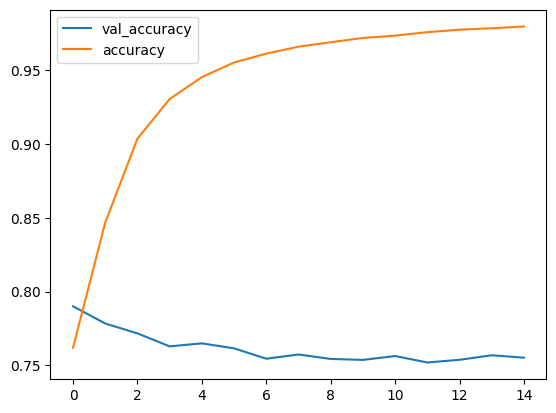

In [ ]:
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.plot(history.history["accuracy"], label="accuracy")
plt.legend()

In [ ]:
model_predictions = model.predict(test_dataset)

485/485 [==============================] - 6s 8ms/step


In [ ]:
model_y_pred = tf.math.round(tf.squeeze(model_predictions))

In [ ]:
model_y_pred[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([1., 0., 0., 0., 0.], dtype=float32)>

In [ ]:
evaluate_predictions(dfTest["sentiment"].to_numpy(),model_y_pred)

{'accuracy': 0.7527017000548405,
 'precision': 0.7771656602041177,
 'recall': 0.7092397434657901,
 'f1': 0.7522381204144283}

In [ ]:
model_Conv = tf.keras.Sequential([
    text_vectorization,
    tf.keras.layers.Embedding(input_dim=len(vocab), output_dim=128),
    tf.keras.layers.Conv1D(128,5,padding="valid"),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Conv1D(128,5,padding="same"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation="sigmoid")
])

model_Conv.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
history_Conv = model_Conv.fit(train_dataset, epochs=15,
                              steps_per_epoch=len(train_dataset),
                              validation_data=test_dataset,
                              validation_steps = len(test_dataset))

Epoch 1/15
1172/1172 [==============================] - 46s 35ms/step - loss: 0.4992 - accuracy: 0.7552 - val_loss: 0.4649 - val_accuracy: 0.7841
Epoch 2/15
1172/1172 [==============================] - 15s 13ms/step - loss: 0.3277 - accuracy: 0.8587 - val_loss: 0.5422 - val_accuracy: 0.7489
Epoch 3/15
1172/1172 [==============================] - 16s 13ms/step - loss: 0.1842 - accuracy: 0.9256 - val_loss: 0.7377 - val_accuracy: 0.7392
Epoch 4/15
1172/1172 [==============================] - 14s 12ms/step - loss: 0.1210 - accuracy: 0.9529 - val_loss: 0.8583 - val_accuracy: 0.7392
Epoch 5/15
1172/1172 [==============================] - 14s 12ms/step - loss: 0.0948 - accuracy: 0.9634 - val_loss: 1.0352 - val_accuracy: 0.7127
Epoch 6/15
1172/1172 [==============================] - 15s 13ms/step - loss: 0.0818 - accuracy: 0.9686 - val_loss: 1.0433 - val_accuracy: 0.7324
Epoch 7/15
1172/1172 [==============================] - 15s 13ms/step - loss: 0.0681 - accuracy: 0.9740 - val_loss: 1.1222 -

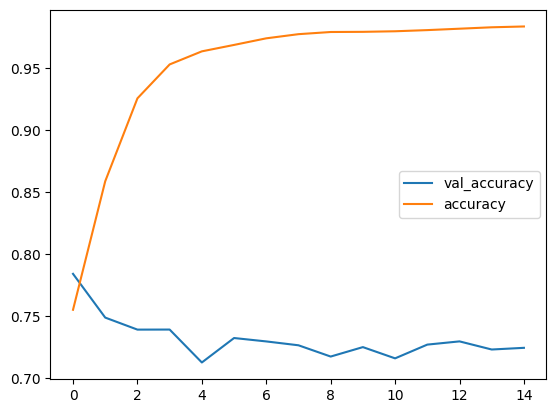

In [ ]:
plt.plot(history_Conv.history["val_accuracy"], label="val_accuracy")
plt.plot(history_Conv.history["accuracy"], label="accuracy")
plt.legend()

In [ ]:
model_Conv_predictions = model_Conv.predict(test_dataset)
model_Conv_y_pred = tf.math.round(tf.squeeze(model_Conv_predictions))
evaluate_predictions(dfTest["sentiment"], model_Conv_y_pred)

485/485 [==============================] - 1s 3ms/step


{'accuracy': 0.724491112616536,
 'precision': 0.7198197062346341,
 'recall': 0.7359889135969577,
 'f1': 0.7244532880758515}

## First Experiments
### What's been achieved so far:
* Defined a baseline model using tf-idf and naive bayes
* Preprocessing dataset in ordet to set up correctly Text Vectorization and Embeddings Layers
  * Used 95% of total words as vocabulary and 95 percentile of sequence length
* Built first model with bidirectional LSTM
  * It overfits... added "aggressive" dropout at 0.5 after each layer. Overfitting mitigated and the results are slightly better than baseline
* Built second model with Convolution 1D
  * This overfits too. Added "aggressive" dropout at 0.5 after each layere here too but not performs well...

### Next Steps to try:
* Remove special characters from input sentences
* Change vocabulary size and sequence length
* Try different kind of neural networks
* Implement some kind of tolerance:
  * for example instead of using  `tf.math.round()` and so bring to one anything above 0.5, use something to flag positive everything above 0.3

